# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint

# Import API key

from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude

from citipy import citipy

# Output File (CSV)

output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes

lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities

lat_lngs = []
cities = []

# Create a set of random lat and lng combinations

lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)

lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination

for lat_lng in lat_lngs:
    
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    
    if city not in cities:
        
        cities.append(city)

# Print the city count to confirm sufficient count

len(cities)

628

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [3]:
# Save config information
    
base_url = "http://api.openweathermap.org/data/2.5/weather?"
api_key = weather_api_key
units = "imperial"

rawjson_list = []
city_list = []
lat_list = []
temp_list = []
maxtemp_list = []
humidity_list = []
cloudiness_list = []
windspeed_list = []

In [5]:
# for loop for api calls

# we need to assure that we don't save "missing data" cities

for num,city in enumerate(cities[:6]):
        
    query_url = f"{base_url}appid={api_key}&q={city}&units={units}"

    weather_response = requests.get(query_url)
    weather_json = weather_response.json()
    weather_city = ""
    
    try:
        
        weather_city = weather_json["name"]
        

        weather_lat = weather_json["coord"]["lat"]
        
        
        weather_temp = weather_json["main"]["temp"]              # in Kelvin, need imperial (degrees F)
        
        
        weather_maxtemp = weather_json["main"]["temp_max"]              # in Kelvin, need imperial (degrees F)
        

        weather_humidity = weather_json["main"]["humidity"]      # not always provided (need try ... except), in %
        

        weather_cloudiness = weather_json["clouds"]["all"]       # in % 
        

        weather_windspeed = weather_json["wind"]["speed"]       # in meter/sec, need imperial (miles/hr)
        
                
    except:
        
        print(f"{num} Info missing for {weather_city} ... skipping!")
        continue        
    
    else:
        
        print(f"{num} Working on {weather_city} ...")
        
        rawjson_list.append(weather_json)
        city_list.append(weather_city)
        lat_list.append(weather_lat)
        temp_list.append(weather_temp)
        maxtemp_list.append(weather_temp)
        humidity_list.append(weather_humidity)
        cloudiness_list.append(weather_cloudiness)
        windspeed_list.append(weather_windspeed)
    
    finally:
    
        time.sleep(2)

print(f"DONE!")

0 Info missing for  ... skipping!
1 Working on Puno ...
2 Working on Bluff ...
3 Working on Surat ...
4 Working on Jamestown ...
5 Working on Nikolskoye ...
DONE!


In [6]:
for rawjson in rawjson_list:
    pprint(rawjson)

{'base': 'stations',
 'clouds': {'all': 60},
 'cod': 200,
 'coord': {'lat': -15.8333, 'lon': -70.0333},
 'dt': 1659048424,
 'id': 3931276,
 'main': {'feels_like': 55.9,
          'grnd_level': 646,
          'humidity': 38,
          'pressure': 1016,
          'sea_level': 1016,
          'temp': 58.57,
          'temp_max': 58.57,
          'temp_min': 58.57},
 'name': 'Puno',
 'sys': {'country': 'PE',
         'id': 8667,
         'sunrise': 1659006312,
         'sunset': 1659047269,
         'type': 1},
 'timezone': -18000,
 'visibility': 10000,
 'weather': [{'description': 'broken clouds',
              'icon': '04n',
              'id': 803,
              'main': 'Clouds'}],
 'wind': {'deg': 96, 'gust': 3.15, 'speed': 2.17}}
{'base': 'stations',
 'clouds': {'all': 86},
 'cod': 200,
 'coord': {'lat': -46.6, 'lon': 168.3333},
 'dt': 1659048426,
 'id': 2206939,
 'main': {'feels_like': 42.73,
          'grnd_level': 1001,
          'humidity': 73,
          'pressure': 1004,
        

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
 # Set up df
    
data = {
        "CITY": [],
        "LAT": [],
        "TEMP": [],
        "MAXTEMP": [],
        "HUMIDITY": [],
        "CLOUDINESS": [],
        "WINDSPEED": [],
        }

cityweather_df = pd.DataFrame(data=data)
    
cityweather_df["CITY"] = city_list
cityweather_df["LAT"] = lat_list
cityweather_df["TEMP"] = temp_list
cityweather_df["MAXTEMP"] = maxtemp_list
cityweather_df["HUMIDITY"] = humidity_list
cityweather_df["CLOUDINESS"] = cloudiness_list
cityweather_df["WINDSPEED"] = windspeed_list

cityweather_df

,CITY,LAT,TEMP,MAXTEMP,HUMIDITY,CLOUDINESS,WINDSPEED
0,Puno,-15.8333,58.57,58.57,38,60,2.17
1,Bluff,-46.6000,47.80,47.80,73,86,11.77
2,Surat,21.1667,80.26,80.26,85,89,6.69
3,Jamestown,42.0970,78.33,78.33,32,0,13.80
4,Nikolskoye,59.7035,57.58,57.58,87,97,3.62


In [8]:
cityweather_df.dtypes

CITY           object
LAT           float64
TEMP          float64
MAXTEMP       float64
HUMIDITY        int64
CLOUDINESS      int64
WINDSPEED     float64
dtype: object

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [9]:
(cityweather_df

     .HUMIDITY
     .gt(100)
     .sum()
)

0

In [10]:
#  Get the indices of cities that have humidity over 100%.


In [11]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

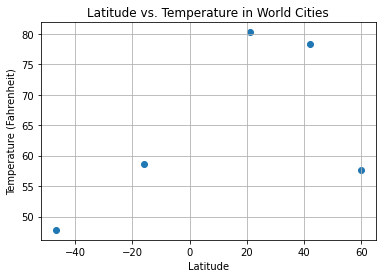

In [12]:
plt.scatter(cityweather_df["LAT"], cityweather_df["TEMP"], marker="o")

plt.title("Latitude vs. Temperature in World Cities")
plt.ylabel("Temperature (Fahrenheit)")
plt.xlabel("Latitude")
plt.grid(True)

# plt.savefig("TemperatureInWorldCities.png")

# Show plot
plt.show()

## Latitude vs. Humidity Plot

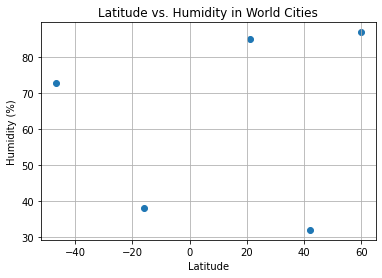

In [13]:
plt.scatter(cityweather_df["LAT"], cityweather_df["HUMIDITY"], marker="o")

plt.title("Latitude vs. Humidity in World Cities")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)

# plt.savefig("HumidityInWorldCities.png")

# Show plot
plt.show()

## Latitude vs. Cloudiness Plot

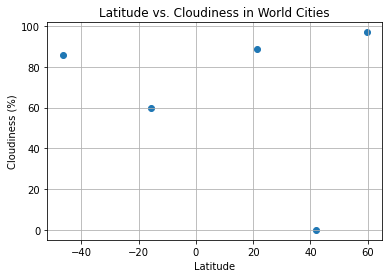

In [14]:
plt.scatter(cityweather_df["LAT"], cityweather_df["CLOUDINESS"], marker="o")

plt.title("Latitude vs. Cloudiness in World Cities")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)

# plt.savefig("CloudinessInWorldCities.png")

# Show plot
plt.show()

## Latitude vs. Wind Speed Plot

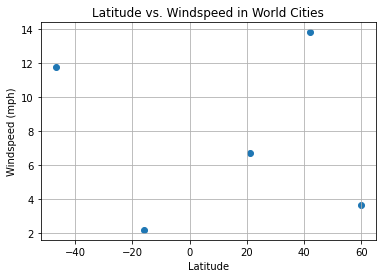

In [15]:
plt.scatter(cityweather_df["LAT"], cityweather_df["WINDSPEED"], marker="o")

plt.title("Latitude vs. Windspeed in World Cities")
plt.ylabel("Windspeed (mph)")
plt.xlabel("Latitude")
plt.grid(True)

# plt.savefig("WindspeedInWorldCities.png")

# Show plot
plt.show()

## Linear Regression

In [16]:
cityweather_df["HEMISPHERE"] = 0

# assign 1 to Northern Hemisphere cities

cityweather_df.loc[(cityweather_df["LAT"] >= 0), "HEMISPHERE"] = 1

northern_latitudes = cityweather_df["HEMISPHERE"] == 1
southern_latitudes = cityweather_df["HEMISPHERE"] == 0

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

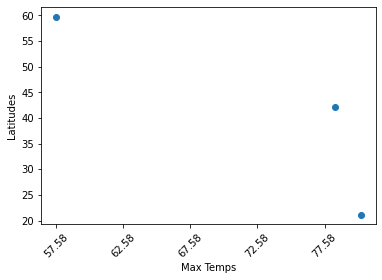

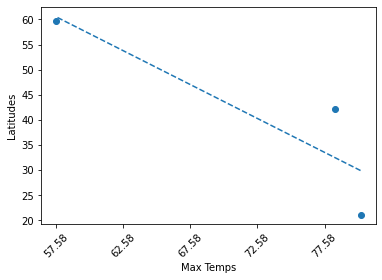

In [17]:
maxtemps = cityweather_df[northern_latitudes]["MAXTEMP"]
latitudes = cityweather_df[northern_latitudes]["LAT"]

plt.scatter(maxtemps, latitudes)
plt.xticks(np.arange(min(maxtemps), max(maxtemps)+1, 5.0), rotation=45)
plt.xlabel("Max Temps")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(maxtemps, latitudes) 

a_fit = a_slope * maxtemps + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(maxtemps, latitudes)
plt.plot(maxtemps, a_fit, "--")

plt.xticks(np.arange(min(maxtemps), max(maxtemps)+1, 5.0), rotation=45)

# plt.xticks(maxtemps, rotation=90)

plt.xlabel("Max Temps")
plt.ylabel("Latitudes")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

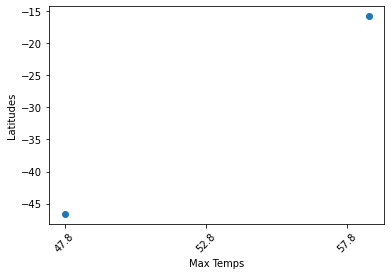

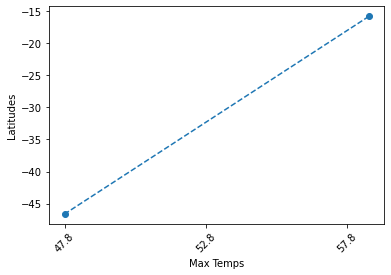

In [18]:
maxtemps = cityweather_df[southern_latitudes]["MAXTEMP"]
latitudes = cityweather_df[southern_latitudes]["LAT"]

plt.scatter(maxtemps, latitudes)
plt.xticks(np.arange(min(maxtemps), max(maxtemps)+1, 5.0), rotation=45)
plt.xlabel("Max Temps")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(maxtemps, latitudes) 

a_fit = a_slope * maxtemps + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(maxtemps, latitudes)
plt.plot(maxtemps, a_fit, "--")
plt.xticks(np.arange(min(maxtemps), max(maxtemps)+1, 5.0), rotation=45)
plt.xlabel("Max Temps")
plt.ylabel("Latitudes")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

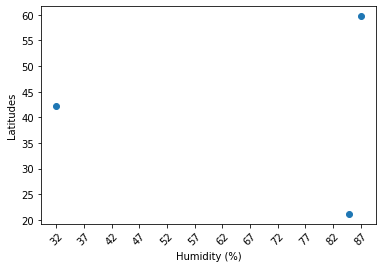

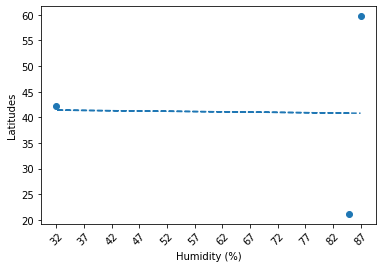

In [19]:
humidities = cityweather_df[northern_latitudes]["HUMIDITY"]
latitudes = cityweather_df[northern_latitudes]["LAT"]

plt.scatter(humidities, latitudes)
plt.xticks(np.arange(min(humidities), max(humidities)+1, 5.0), rotation=45)
plt.xlabel("Humidity (%)")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(humidities, latitudes) 

a_fit = a_slope * humidities + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(humidities, latitudes)
plt.plot(humidities, a_fit, "--")
plt.xticks(np.arange(min(humidities), max(humidities)+1, 5.0), rotation=45)
plt.xlabel("Humidity (%)")
plt.ylabel("Latitudes")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

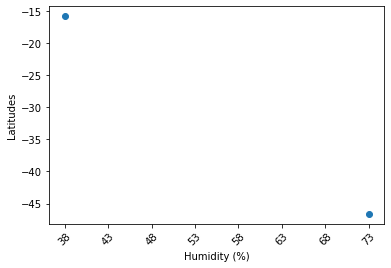

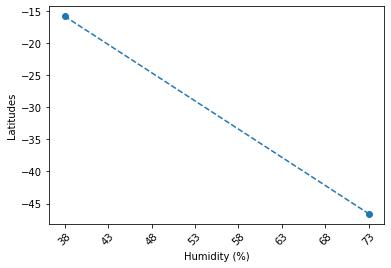

In [20]:
humidities = cityweather_df[southern_latitudes]["HUMIDITY"]
latitudes = cityweather_df[southern_latitudes]["LAT"]

plt.scatter(humidities, latitudes)
plt.xticks(np.arange(min(humidities), max(humidities)+1, 5.0), rotation=45)
plt.xlabel("Humidity (%)")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(humidities, latitudes) 

a_fit = a_slope * humidities + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(humidities, latitudes)
plt.plot(humidities, a_fit, "--")
plt.xticks(np.arange(min(humidities), max(humidities)+1, 5.0), rotation=45)
plt.xlabel("Humidity (%)")
plt.ylabel("Latitudes")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

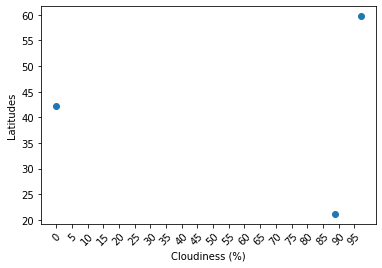

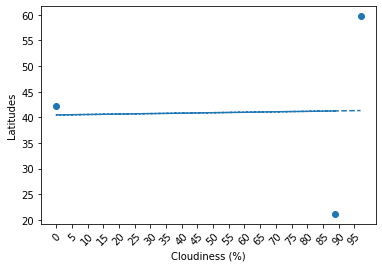

In [21]:
cloudinesses = cityweather_df[northern_latitudes]["CLOUDINESS"]
latitudes = cityweather_df[northern_latitudes]["LAT"]

plt.scatter(cloudinesses, latitudes)
plt.xticks(np.arange(min(cloudinesses), max(cloudinesses)+1, 5.0), rotation=45)
plt.xlabel("Cloudiness (%)")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(cloudinesses, latitudes) 

a_fit = a_slope * cloudinesses + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(cloudinesses, latitudes)
plt.plot(cloudinesses, a_fit, "--")
plt.xticks(np.arange(min(cloudinesses), max(cloudinesses)+1, 5.0), rotation=45)
plt.xlabel("Cloudiness (%)")
plt.ylabel("Latitudes")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

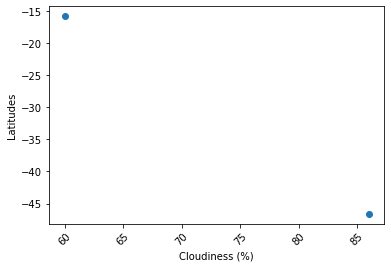

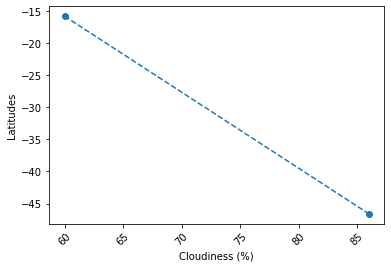

In [22]:
cloudinesses = cityweather_df[southern_latitudes]["CLOUDINESS"]
latitudes = cityweather_df[southern_latitudes]["LAT"]

plt.scatter(cloudinesses, latitudes)
plt.xticks(np.arange(min(cloudinesses), max(cloudinesses)+1, 5.0), rotation=45)
plt.xlabel("Cloudiness (%)")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(cloudinesses, latitudes) 

a_fit = a_slope * cloudinesses + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(cloudinesses, latitudes)
plt.plot(cloudinesses, a_fit, "--")
plt.xticks(np.arange(min(cloudinesses), max(cloudinesses)+1, 5.0), rotation=45)
plt.xlabel("Cloudiness (%)")
plt.ylabel("Latitudes")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

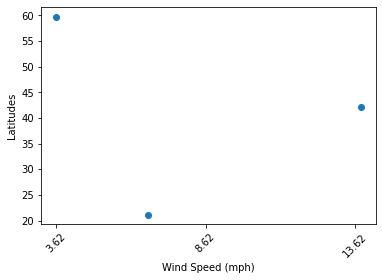

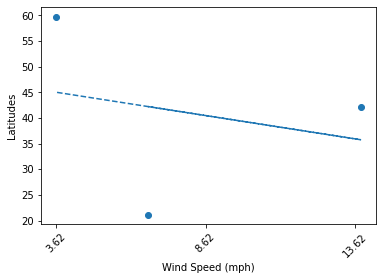

In [23]:
windspeeds = cityweather_df[northern_latitudes]["WINDSPEED"]
latitudes = cityweather_df[northern_latitudes]["LAT"]

plt.scatter(windspeeds, latitudes)
plt.xticks(np.arange(min(windspeeds), max(windspeeds)+1, 5.0), rotation=45)
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(windspeeds, latitudes) 

a_fit = a_slope * windspeeds + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(windspeeds, latitudes)
plt.plot(windspeeds, a_fit, "--")
plt.xticks(np.arange(min(windspeeds), max(windspeeds)+1, 5.0), rotation=45)
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Latitudes")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

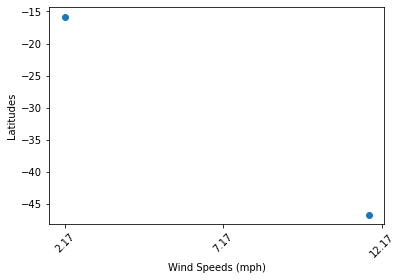

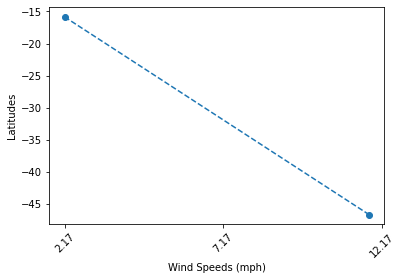

In [24]:
windspeeds = cityweather_df[southern_latitudes]["WINDSPEED"]
latitudes = cityweather_df[southern_latitudes]["LAT"]

plt.scatter(windspeeds, latitudes)
plt.xticks(np.arange(min(windspeeds), max(windspeeds)+1, 5.0), rotation=45)
plt.xlabel("Wind Speeds (mph)")
plt.ylabel("Latitudes")
plt.show()

a_slope, a_int, a_r, a_p, a_std_err = linregress(windspeeds, latitudes) 

a_fit = a_slope * windspeeds + a_int 

 # Plot the linear model on top of scatter plot 
    
plt.scatter(windspeeds, latitudes)
plt.plot(windspeeds, a_fit, "--")
plt.xticks(np.arange(min(windspeeds), max(windspeeds)+1, 5.0), rotation=45)
plt.xlabel("Wind Speeds (mph)")
plt.ylabel("Latitudes")
plt.show()